# K-Means Algorithm

In [31]:
import numpy as np
import matplotlib.pyplot as plt

## Toy Dataset

As before, let us generate a toy dataset.

In [32]:
rng = np.random.default_rng(seed = 138)
mus = np.array([
    [-3, 3],
    [3, -3],
    [3, 3]
])
cov = np.eye(2)
n = 60
xvals = [rng.multivariate_normal(
    mus[i], cov, size = n // 3)
    for i in range(3)]
X = np.concatenate(xvals, axis = 0).T
X = X.astype(np.float32)
X.shape

(2, 60)

### Visualize the dataset

As before, let us visualize the dataset using a scatter plot.

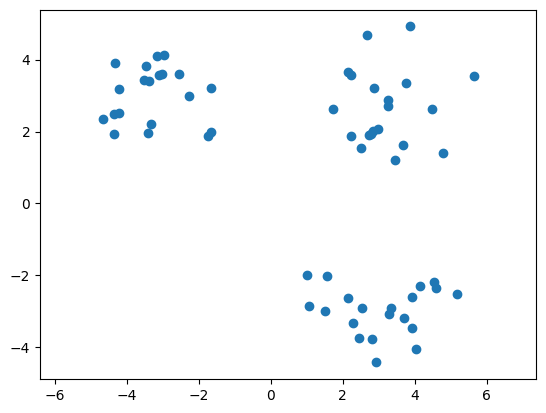

In [33]:
plt.scatter(X[0, :], X[1, :])
plt.axis('equal');

## Step-1: Initialization

Let us choose $k$ points uniformly at random from the dataset and call them the $k$ initial means. For this example, we shall use $k = 3$.

In [34]:
k = 3
d, n = X.shape
ind = rng.choice(
    np.arange(n),
    size = k,
    replace = False
)
mus = X[:, ind]
mus.shape

(2, 3)

`mus[:, j]` gives the mean of the $j^{th}$ cluster. The array `mus` is of shape $d \times k$. Each column corresponds to a mean.

## Step-2: Cluster Assignment

We will now compute the cluster closest to each point in the dataset and store them in the array $\mathbf{z}$. Clusters are indexed from $0$ to $k - 1$.

In [35]:
z = np.zeros(n)
for i in range(n):
    dist = np.linalg.norm(
        mus - X[:, i].reshape(d, 1),
        axis = 0
    )
    z[i] = np.argmin(dist)

## Step-3: Cluster centers

It is now time to recompute the cluster centers. If a cluster has at least one (actually two) point assigned to it, we need to update its center to the mean of all points assigned to it.*italicised text*

In [36]:
for j in range(k):
    if np.any(z == j):
        mus[:, j] = X[:, z == j].mean(axis = 1)

## K-means function

We now have all the ingredients to turn this into a function. We need to loop through steps two and three until convergence. Recall that k-means always converges. The convergence criterion is to stop iterating when the cluster assignments do not change. To help with this, we will introduce a new array, `z_prev`, that keeps track of the previous cluster assignment.


In [37]:
def k_means(X, k = 3):
    d, n = X.shape
    # Step-1: Initialization
    ind = rng.choice(
        np.arange(n),
        size = k,
        replace = False
        )
    mus = X[:, ind]
    z_prev, z = np.zeros(n), np.ones(n)
    while not np.array_equal(z_prev, z):
        z_prev = z.copy()
        # Step-2: Cluster Assignment
        for i in range(n):
            dist = np.linalg.norm(
                mus - X[:, i].reshape(d, 1),
                axis = 0
                )
            z[i] = np.argmin(dist)
        # Step-3: Compute centers
        for j in range(k):
            if np.any(z == j):
                mus[:, j] = X[:, z == j].mean(axis = 1)
    return z.astype(np.int8), mus

### Visualize

Let us now visualize the clusters we have obtained by running k-means on the toy dataset. The cluster centers are represented in black color.

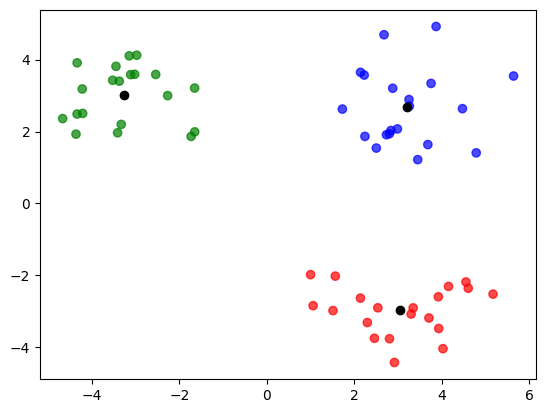

In [38]:
z, mus = k_means(X)
colors = np.array(['red', 'green', 'blue'])
plt.scatter(
    X[0, :],
    X[1, :],
    c = colors[z],
    alpha = 0.7
    )
plt.scatter(
    mus[0, :],
    mus[1, :],
    color = 'black');

A few additional points related to `NumPy`. `z_prev.copy()` does a deep copy in NumPy. To see why we need a deep copy, consider:

In [39]:
a = np.array([1, 2, 3])
b = a
b[0] += 100
print(a, b)

[101   2   3] [101   2   3]


Notice how both `a` and `b` change when only `b` is updated. This is because, both `a` and `b` point to the same object. To avoid this, we have:

In [40]:
a = np.array([1, 2, 3])
b = np.copy(a)
b[0] += 100
print(a, b)

[1 2 3] [101   2   3]


The `astype` method allows us to typecast arrays.

In [41]:
a = np.array([1, 2, 3])
print(a.dtype)
a = a.astype(np.float32)
print(a.dtype)

int64
float32


# Image Segmentation

Let us look at a small application of k-means algorithm: image segmentation. This application is by no means the best way of segmenting images. It is just given here to demonstrate the idea.

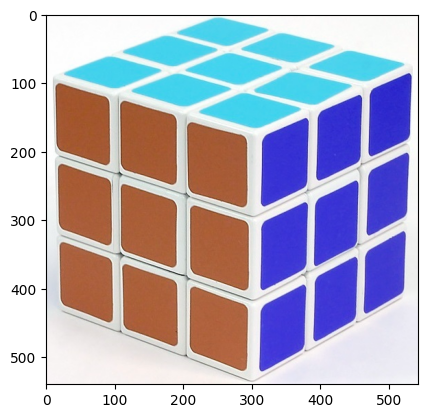

In [42]:
import cv2
img = cv2.imread('cube.jpg')
plt.imshow(img);

This is rather big. Let us have a more manageable size.

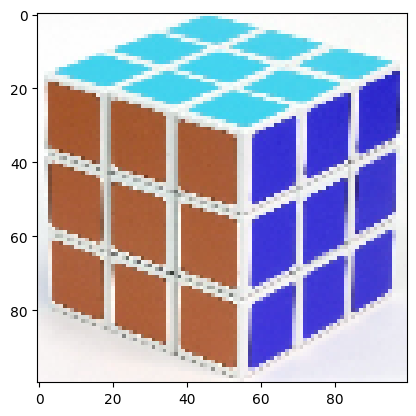

In [43]:
img = cv2.resize(img, (100, 100))
plt.imshow(img);

This is a RGB image having $100 \times 100 = 10,000$ pixels with three channels. We can view this as a dataset of $10,000$ points in $\mathbb{R}^{3}$ and run k-means on it. This requires us to carefully reshape the image. For compatibility with some arithmetic operations, let us convert the dataset to `float`.

In [44]:
img = img.reshape(-1, 3).T
img = img.astype(np.float32)

We now run k-means with $k = 4$.

In [45]:
d, n = img.shape
rng = np.random.default_rng(seed = 42)
# change seed value to see the effect
z, mus = k_means(
    img,
    k = 4
    )

Let us now replace each pixel in the dataset with the cluster center closest to it.

In [46]:
for i in range(n):
    img[:, i] = mus[:, z[i]]

Let us now reshape the data back into the form of an image and see what we have:

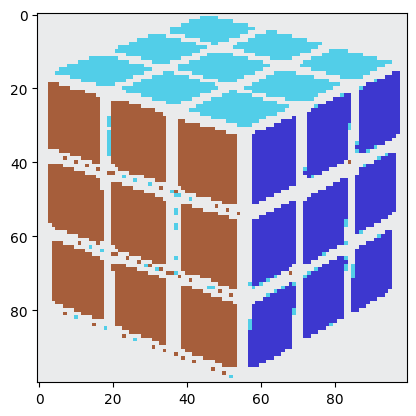

In [47]:
img = img.T.reshape(100, 100, 3).astype(int)
plt.imshow(img);

It seems as though we have achieved nothing in the process. This image looks, if anything, worse than the original image we had. It is a better idea to run k-means on different kinds of images to see how it segments them.

But what we have certainly achieved is some kind of compression in storage. Though there are $10,000$ pixels, we only need to store the following:

- $10,000$ `int` values that represent the cluster indicators for the $10,000$ pixels
- $4$ means, which is $4 \times 3 = 12$ `float` values

On the other hand, we had to store $10,000 \times 3$ `float` values for the original image. The ratio turns out to be:


In [48]:
# Not exact values
float_size = 8 # assuming we use float32
int_size = 1 # assuming we use int8
num = 10_000 * 3 * float_size
den = 10_000 * int_size + 12 * float_size
np.round(num / den)

24.0